## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizontal_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\segmentAnything\\full\\wavelet\\horizontal\\gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


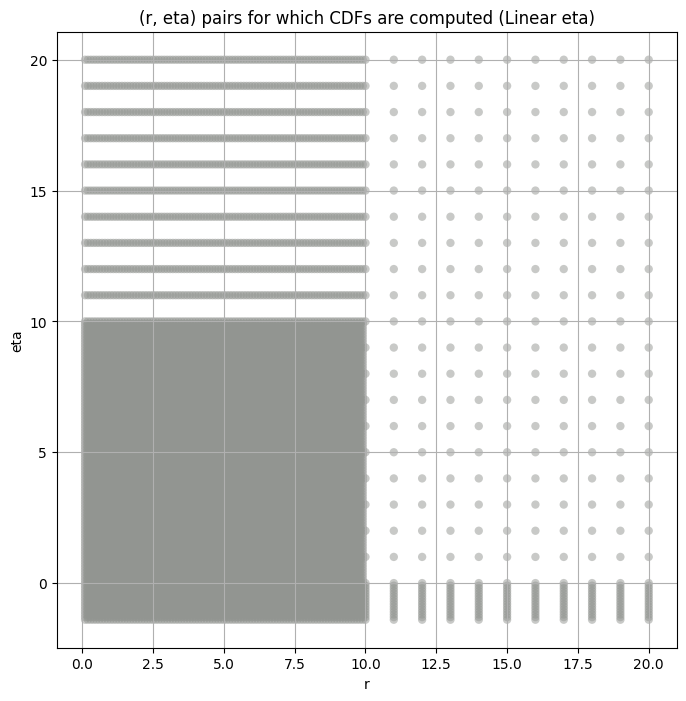

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,16169.523000,15177.119000,17195.475000,2.213300,1.761543,2.715613,7072
3,3762.386200,3538.720000,3994.053200,3.497146,2.946661,4.127098,28288
4,920.339200,858.125370,985.152100,5.063853,4.278093,5.952429,113152
5,219.233800,203.019130,236.125370,6.788183,5.738397,8.011982,452608
6,50.127670,46.053883,54.402360,8.402071,7.057478,9.979578,1810432
7,11.506187,10.512554,12.558530,10.125872,8.530455,12.001128,7241728
8,2.649243,2.404634,2.908538,11.729738,9.772912,14.093412,28966912
9,0.651531,0.588100,0.718601,13.221848,10.936687,15.909588,115867648
10,0.177396,0.159134,0.197087,15.001799,12.350390,17.925581,463470592


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,16169.523000,16169.523438,14467.028320,13417.888672,12603.753906,11896.242188,10713.160156,9754.478516,8914.919922,8180.561035,7549.646484,6032.446777
3,3762.386200,3762.386230,3594.977539,3478.152588,3376.463379,3286.505859,3131.931152,2998.316162,2879.641602,2771.975830,2674.118896,2425.281250
4,920.339200,920.339172,902.404297,888.443970,876.308777,865.227600,845.396057,827.551819,811.195312,796.107422,782.007507,744.578857
5,219.233800,219.233795,214.177444,210.312119,206.904160,203.817734,198.362869,193.531586,189.152359,185.120605,181.371719,171.347107
6,50.127670,50.127670,48.799995,47.801151,46.931732,46.145031,44.752964,43.525181,42.417557,41.400974,40.458771,37.967422
7,11.506187,11.506186,11.169895,10.915277,10.694327,10.494769,10.140529,9.829136,9.548547,9.291634,9.054048,8.429328
8,2.649243,2.649243,2.562710,2.498228,2.442456,2.392352,2.303921,2.226638,2.157382,2.094288,2.036182,1.884647
9,0.651531,0.651531,0.628158,0.610848,0.595993,0.582742,0.559516,0.539364,0.521420,0.505166,0.490264,0.451642
10,0.177396,0.177395,0.170499,0.165245,0.160744,0.156747,0.149802,0.143847,0.138600,0.133894,0.129619,0.118697


####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.06610622008709216 16169.523


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.06611856736294425 14467.028


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.06639644139370976 13417.889


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06640236272410771 12603.754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.06639772048387993 11896.242


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.06640180207242091 10713.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.06658333850957787 9754.479


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.06676719587756108 8914.92


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.06706420581267236 8180.561


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.07045125714897948 7549.6465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.09092305136616763 6032.447
Number of samples: 7072, Without approximation : 7072


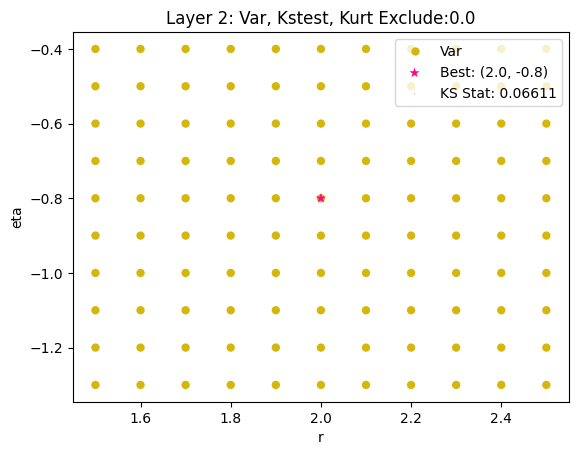

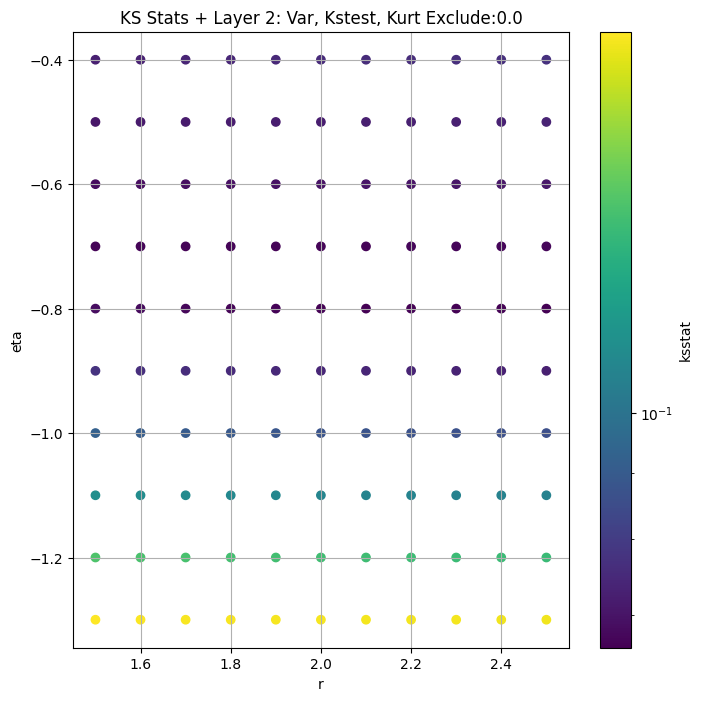

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.043382659927928835 3762.3862


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.043377262848235454 3594.9775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.043383401988268344 3478.1526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0433844021800488 3376.4634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.043386942488903346 3286.5059


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.04341805683529271 3131.9312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04429447393430175 2998.3162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.044585899148344266 2879.6416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.044595265359701985 2771.9758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.04468160793268672 2674.119


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.04468227777312428 2425.2812
Number of samples: 28288, Without approximation : 28288


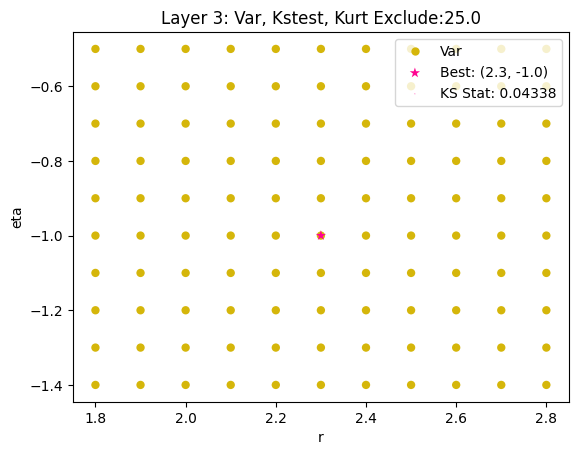

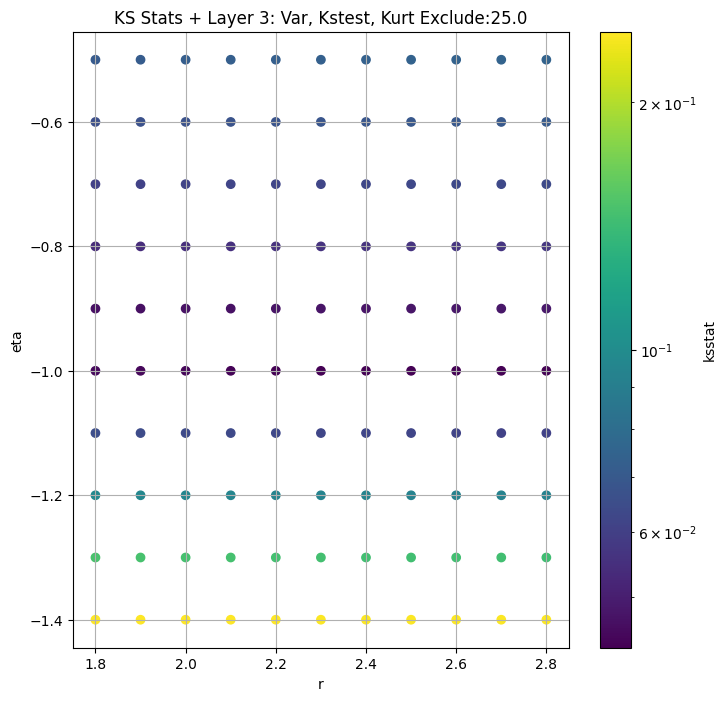

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03127558907469119 920.3392


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.03133240210068561 902.4043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.03131294122235295 888.444


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.031295655961153857 876.3088


  0%|          | 0/12760 [00:00<?, ?it/s]

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [ ]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

In [ ]:
master_df.filter(regex="best.*")

In [ ]:
eng.quit()